In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [160]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [7]:
f = pd.read_excel('/ocean/vdo/MEOPAR/2016_Nutrients_20180110_CN_edits.xlsx')
f.keys()

Index(['Crew', 'Date', 'Time of Sample', 'Lat_reported', 'Long_reported',
       'Latitude', 'Longitude', 'Station', 'Depth', 'NO3+NO', 'PO4',
       'Samples missing!', 'Unnamed: 12', 'Samples in lab.'],
      dtype='object')

In [72]:
f = f.drop(f.keys()[11:], axis=1)

In [73]:
f.shape

(1553, 11)

In [74]:
f = f.dropna(subset = ['Date', 'Time of Sample', 'Latitude', 'Longitude', 'Depth', 'NO3+NO'])

In [75]:
f[:5]

,Crew,Date,Time of Sample,Lat_reported,Long_reported,Latitude,Longitude,Station,Depth,NO3+NO,PO4
0,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.000,SS-46131,0,18.491,1.951
1,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.000,SS-46131,0,18.662,1.863
2,Sentry Shoal,2016-01-22,17:30:00,49° 92.000,125° 00.000,50.533333,-125.000,SS-46131,0,19.621,1.561
7,Campbell River,2016-02-16,09:58:00,50° 04.900,125° 15.900,50.081667,-125.265,CR-2,0,24.163,2.237
8,Campbell River,2016-02-16,09:58:00,50° 04.900,125° 15.900,50.081667,-125.265,CR-2,20,24.326,2.787


In [76]:
local = pytz.timezone ("America/Los_Angeles")

In [77]:
g = nc.Dataset('/results/SalishSea/nowcast-green/01jan18/SalishSea_1d_20180101_20180101_dia2_T.nc')

In [78]:
np.argmin(np.abs(g.variables['deptht'][:] - 20))

18

In [79]:
pd.to_datetime(pd.Timestamp(f['Date'].values[0]))

Timestamp('2016-01-22 00:00:00')

In [80]:
import datetime

In [81]:
datetimes = np.array([])
for index in f.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(f['Date'][index])), 
                          f['Time of Sample'][index])
    datetimes = np.append(datetimes, dt)

In [82]:
f.shape

(1374, 11)

In [83]:
datetimes.shape

(1374,)

In [84]:
f = f.assign(datetime = datetimes)

In [85]:
f.shape

(1374, 12)

In [93]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_ni = np.array([])
list_of_model_ni = np.array([])
list_of_depths = np.array([])
for n in f.index:
    Yind, Xind = geo_tools.find_closest_model_point(f.Longitude[n], 
                                                        f.Latitude[n], 
                                                        X, Y, land_mask = bathy.mask)
    if f['Depth'][n] == 0:
        depth = 0
    elif f['Depth'][n] == 20:
        depth = 18
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(f['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))

        list_of_lons = np.append(list_of_lons, f.Longitude[n])
        list_of_lats = np.append(list_of_lats, f.Latitude[n])
        list_of_datetimes = np.append(list_of_datetimes, date)
        if f['NO3+NO'][n] == '<0':
            list_of_cs_ni = np.append(list_of_cs_ni, 0)
        else:
            list_of_cs_ni = np.append(list_of_cs_ni, float(f['NO3+NO'][n]))
        list_of_model_ni = np.append(list_of_model_ni, ni_val)
        list_of_depths = np.append(list_of_depths, depth)

In [94]:
list_of_lats.shape

(1363,)

In [95]:
list_of_model_ni.shape

(1363,)

In [9]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

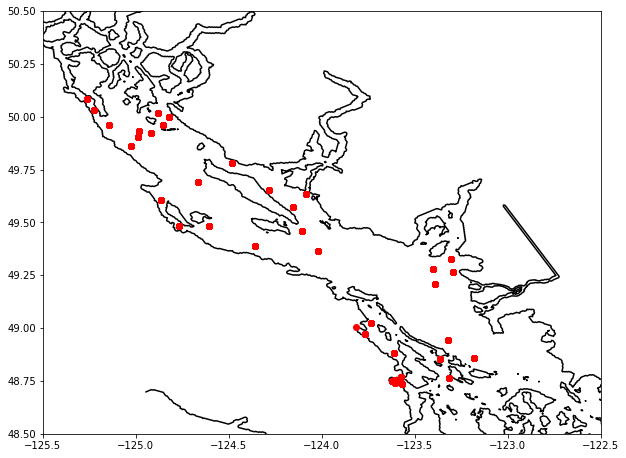

In [104]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 50.5)
ax.set_xlim(-125.5, -122.5);

In [62]:
list_of_cs_ni.shape

(1363,)

surface bias =  -0.669838703293
surface RMSE = 6.65504480557
surface Willmott = 0.791686298012
20m bias =  0.0691347368161
20m RMSE = 9.00730510459
20m Willmott = 0.528732445315
bias =  -0.308213402814
RMSE = 7.89421610707
Willmott = 0.78486662202


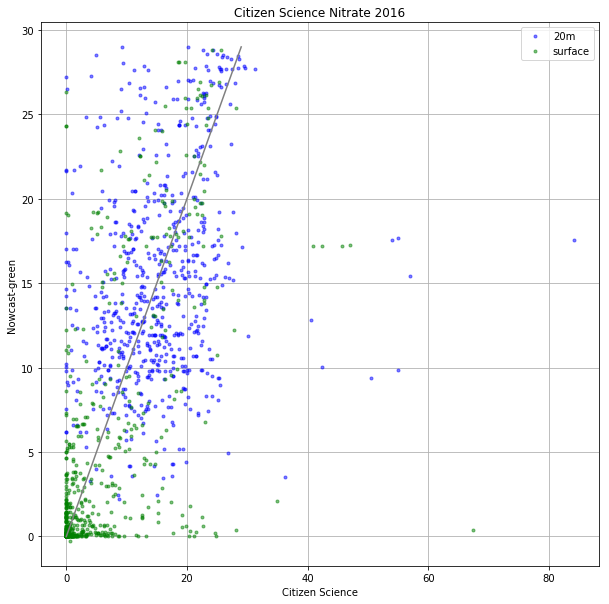

In [100]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_ni[list_of_depths == 18], list_of_model_ni[list_of_depths == 18],  
        'b.', alpha = 0.5, label = '20m')
ax.plot(list_of_cs_ni[list_of_depths == 0], list_of_model_ni[list_of_depths==0],  
        'g.', alpha = 0.5, label = 'surface')
ax.plot(np.arange(0,30), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Nitrate 2016')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths == 0]) 
                               + np.mean(list_of_model_ni[list_of_depths == 0])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths == 0] 
                                              - list_of_cs_ni[list_of_depths == 0])**2) /
                              len(list_of_cs_ni[list_of_depths == 0]))))
xbar = np.mean(list_of_cs_ni[list_of_depths == 0])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths == 0] 
                                             - list_of_cs_ni[list_of_depths == 0])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths == 0] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths == 0] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths == 18]) 
                               + np.mean(list_of_model_ni[list_of_depths == 18])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths == 18] 
                                              - list_of_cs_ni[list_of_depths == 18])**2) /
                              len(list_of_cs_ni[list_of_depths == 18]))))
xbar = np.mean(list_of_cs_ni[list_of_depths == 18])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths == 18] 
                                             - list_of_cs_ni[list_of_depths == 18])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths == 18] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths == 18] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - list_of_cs_ni)**2) /
                              len(list_of_cs_ni))))
xbar = np.mean(list_of_cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - list_of_cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(list_of_cs_ni - xbar))**2))))

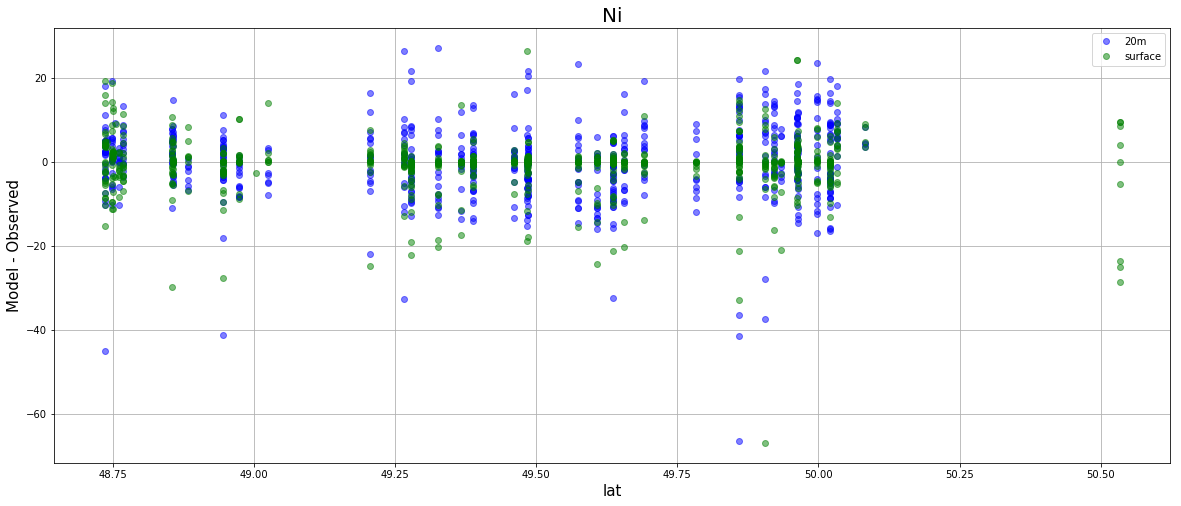

In [101]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lats[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

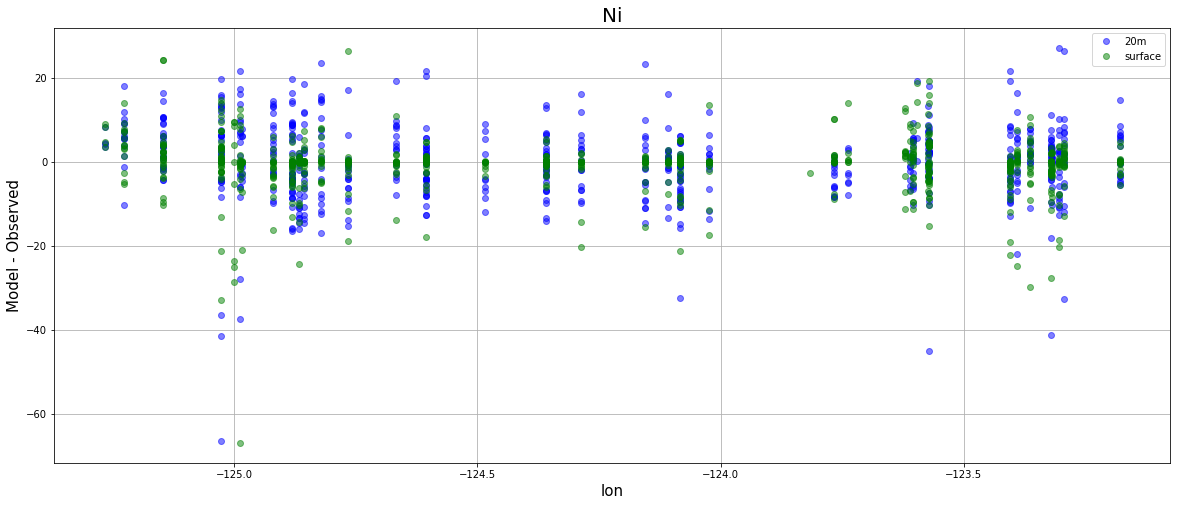

In [102]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lons[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

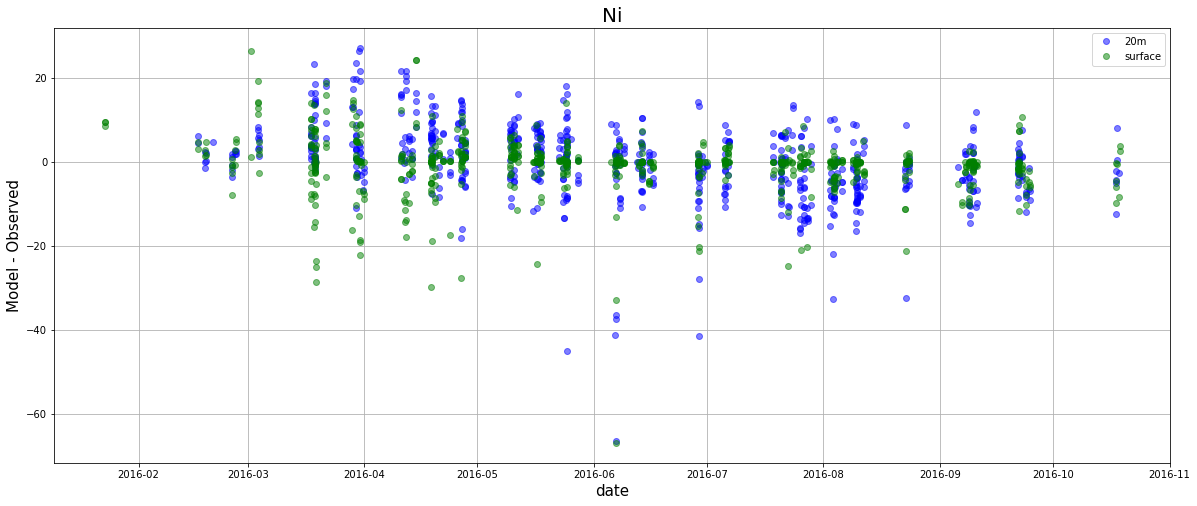

In [103]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_datetimes[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

In [107]:
g = pd.read_excel('/ocean/vdo/MEOPAR/2016_Nutrients_20180110_CN_edits.xlsx', sheetname =1)
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time of Sample', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM',
       'Date doesn't match', 'Unnamed: 10'],
      dtype='object')

In [108]:
g[:5]

,Site ID,DDMMYYYY,Time of Sample,Lat_reported,Long_reported,Latitude,Longitude,Depth,SiO2 µM,Date doesn't match,Unnamed: 10
0,BS-1,2016-06-08,16:30:00,49° 36.500,124° 52.000,49.608333,-124.866667,20,42.35500,NaN,NaN
1,BS-1,2016-06-08,16:30:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,4.91890,NaN,NaN
2,BS-1,2016-06-28,14:56:00,49° 36.500,124° 52.000,49.608333,-124.866667,20,38.35056,NaN,NaN
3,BS-1,2016-07-20,13:45:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,29.16012,NaN,NaN
4,BS-1,2016-07-20,13:45:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,29.37894,NaN,NaN


In [109]:
g.shape

(842, 11)

In [110]:
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time of Sample', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM',
       'Date doesn't match', 'Unnamed: 10'],
      dtype='object')

In [111]:
g = g.drop(g.keys()[9:], axis=1)
g.shape

(842, 9)

In [113]:
g = g.dropna(subset = ['DDMMYYYY', 'Time of Sample', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM'])
g.shape

(826, 9)

In [118]:
g.Depth.unique()

array([20, 'S', 10, 5, 0, 30], dtype=object)

In [123]:
h = nc.Dataset('/results/SalishSea/nowcast-green/01jan18/SalishSea_1d_20180101_20180101_ptrc_T.nc')

In [131]:
g.loc[g['Longitude'] < -200, 'Longitude'] = -123.31833333

/home/vdo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [133]:
g.loc[g['Latitude'] < 30, 'Latitude'] = 48.7616666666667

/home/vdo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [136]:
datetimes = np.array([])
for index in g.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(g['DDMMYYYY'][index])), 
                          g['Time of Sample'][index])
    datetimes = np.append(datetimes, dt)
g = g.assign(datetime = datetimes)

In [137]:
g.shape

(826, 10)

In [139]:
list_of_lons2 = np.array([])
list_of_lats2 = np.array([])
list_of_datetimes2 = np.array([])
list_of_cs_si = np.array([])
list_of_model_si = np.array([])
list_of_depths2 = np.array([])
for n in g.index:
    Yind, Xind = geo_tools.find_closest_model_point(g.Longitude[n], 
                                                        g.Latitude[n], 
                                                        X, Y, land_mask = bathy.mask)
    if g['Depth'][n] == 0:
        depth = 0
    elif g['Depth'][n] == 20:
        depth = 18
    elif g['Depth'][n] == 10:
        depth = 9
    elif g['Depth'][n] == 5:
        depth = 4
    elif g['Depth'][n] == 30:
        depth = 21
    elif g['Depth'][n] == 'S':
        depth = 0
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(g['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))

        list_of_lons2 = np.append(list_of_lons2, g.Longitude[n])
        list_of_lats2 = np.append(list_of_lats2, g.Latitude[n])
        list_of_datetimes2 = np.append(list_of_datetimes2, date)
        if g['SiO2 µM'][n] < 0:
            list_of_cs_si = np.append(list_of_cs_si, 0)
        else:
            list_of_cs_si = np.append(list_of_cs_si, float(g['SiO2 µM'][n]))
        list_of_model_si = np.append(list_of_model_si, si_val)
        list_of_depths2 = np.append(list_of_depths2, depth)

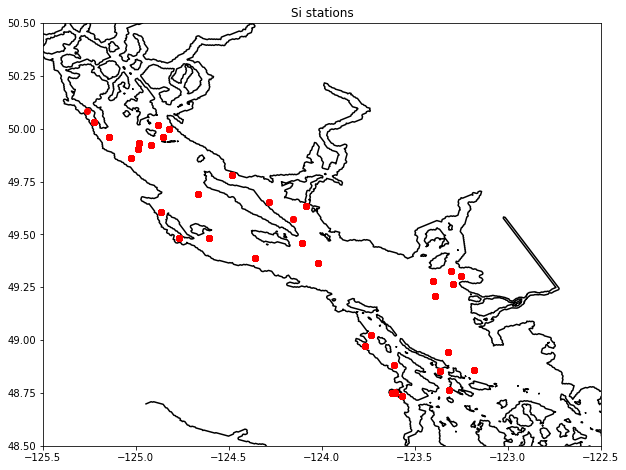

In [140]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons2, list_of_lats2, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_title('Si stations')
ax.set_ylim(48.5, 50.5)
ax.set_xlim(-125.5, -122.5);

surface bias =  -13.9657071841
surface RMSE = 19.7136455872
surface Willmott = 0.626764934218
20m bias =  -17.7304283332
20m RMSE = 21.6986410356
20m Willmott = 0.465754902548
bias =  -15.815908024
RMSE = 20.6995655709
Willmott = 0.63301571957


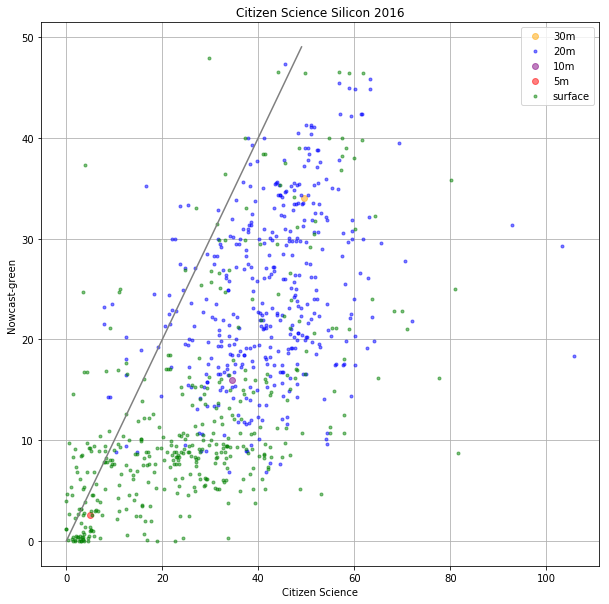

In [151]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_si[list_of_depths2 == 21], list_of_model_si[list_of_depths2 == 21],  
        'o', color = 'orange', alpha = 0.5, label = '30m')
ax.plot(list_of_cs_si[list_of_depths2 == 18], list_of_model_si[list_of_depths2 == 18],  
        'b.', alpha = 0.5, label = '20m')
ax.plot(list_of_cs_si[list_of_depths2 == 9], list_of_model_si[list_of_depths2 == 9],  
        'o', color = 'purple', alpha = 0.5, label = '10m')
ax.plot(list_of_cs_si[list_of_depths2 == 4], list_of_model_si[list_of_depths2 == 4],  
        'ro', alpha = 0.5, label = '5m')
ax.plot(list_of_cs_si[list_of_depths2 == 0], list_of_model_si[list_of_depths2==0],  
        'g.', alpha = 0.5, label = 'surface')
ax.plot(np.arange(0,50), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Silicon 2016')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths2 == 0]) 
                               + np.mean(list_of_model_si[list_of_depths2 == 0])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths2 == 0] 
                                              - list_of_cs_si[list_of_depths2 == 0])**2) /
                              len(list_of_cs_si[list_of_depths2 == 0]))))
xbar = np.mean(list_of_cs_si[list_of_depths2 == 0])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths2 == 0] 
                                             - list_of_cs_si[list_of_depths2 == 0])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths2 == 0] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths2 == 0] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths2 == 18]) 
                               + np.mean(list_of_model_si[list_of_depths2 == 18])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths2 == 18] 
                                              - list_of_cs_si[list_of_depths2 == 18])**2) /
                              len(list_of_cs_si[list_of_depths2 == 18]))))
xbar = np.mean(list_of_cs_si[list_of_depths2 == 18])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths2 == 18] 
                                             - list_of_cs_si[list_of_depths2 == 18])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths2 == 18] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths2 == 18] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - list_of_cs_si)**2) /
                              len(list_of_cs_si))))
xbar = np.mean(list_of_cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - list_of_cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(list_of_cs_si - xbar))**2))))

In [150]:
np.histogram(list_of_depths2, bins = [-1, 3, 7, 10, 20, 25])

(array([411,   1,   1, 403,   1]), array([-1,  3,  7, 10, 20, 25]))

# 411 samples at surface, 403 samples at 20m, 1 sample at 5, 10, and 30m

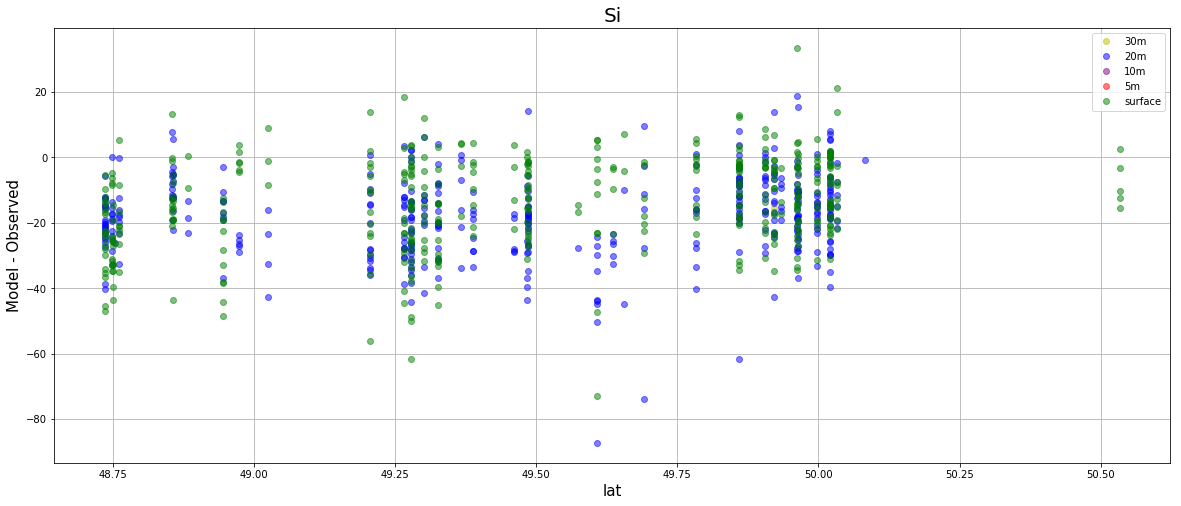

In [157]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats2[list_of_depths2 == 21], 
        list_of_model_si[list_of_depths2 == 21] 
        - list_of_cs_si[list_of_depths2 == 21], 'yo', alpha = 0.5, label = '30m')
ax.plot(list_of_lats2[list_of_depths2 == 18], 
        list_of_model_si[list_of_depths2 == 18] 
        - list_of_cs_si[list_of_depths2 == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lats2[list_of_depths2 == 9], 
        list_of_model_si[list_of_depths2 == 9] 
        - list_of_cs_si[list_of_depths2 == 9], 'o', color = 'purple', alpha =0.5, label = '10m')
ax.plot(list_of_lats2[list_of_depths2 == 4], 
        list_of_model_si[list_of_depths2 == 4] 
        - list_of_cs_si[list_of_depths2 == 4], 'ro', alpha =0.5, label = '5m')
ax.plot(list_of_lats2[list_of_depths2 == 0], 
        list_of_model_si[list_of_depths2 == 0] 
        - list_of_cs_si[list_of_depths2 == 0], 'go', alpha =0.5, label = 'surface')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

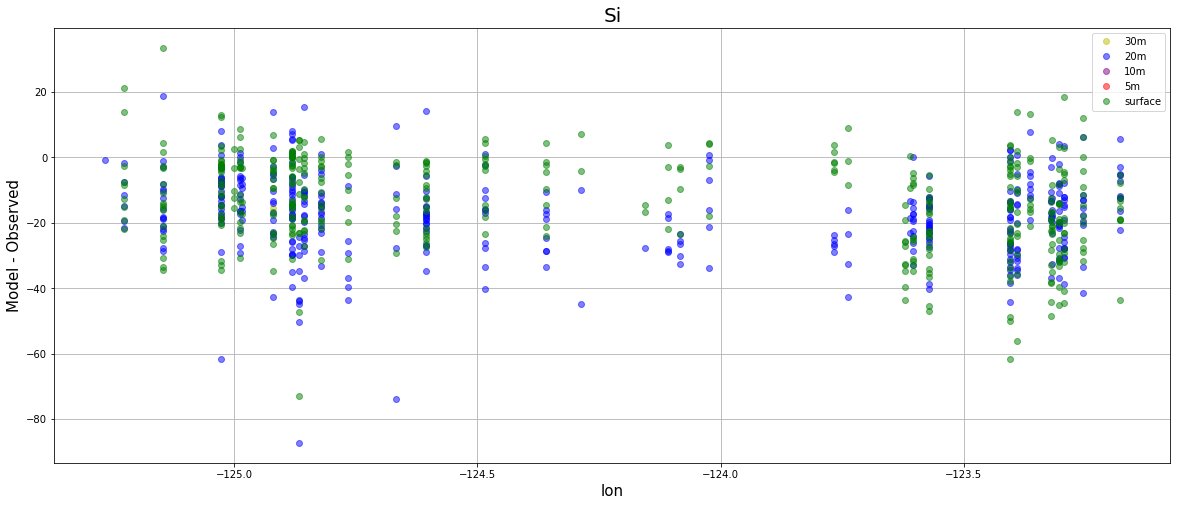

In [158]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons2[list_of_depths2 == 21], 
        list_of_model_si[list_of_depths2 == 21] 
        - list_of_cs_si[list_of_depths2 == 21], 'yo', alpha = 0.5, label = '30m')
ax.plot(list_of_lons2[list_of_depths2 == 18], 
        list_of_model_si[list_of_depths2 == 18] 
        - list_of_cs_si[list_of_depths2 == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lons2[list_of_depths2 == 9], 
        list_of_model_si[list_of_depths2 == 9] 
        - list_of_cs_si[list_of_depths2 == 9], 'o', color = 'purple', alpha =0.5, label = '10m')
ax.plot(list_of_lons2[list_of_depths2 == 4], 
        list_of_model_si[list_of_depths2 == 4] 
        - list_of_cs_si[list_of_depths2 == 4], 'ro', alpha =0.5, label = '5m')
ax.plot(list_of_lons2[list_of_depths2 == 0], 
        list_of_model_si[list_of_depths2 == 0] 
        - list_of_cs_si[list_of_depths2 == 0], 'go', alpha =0.5, label = 'surface')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

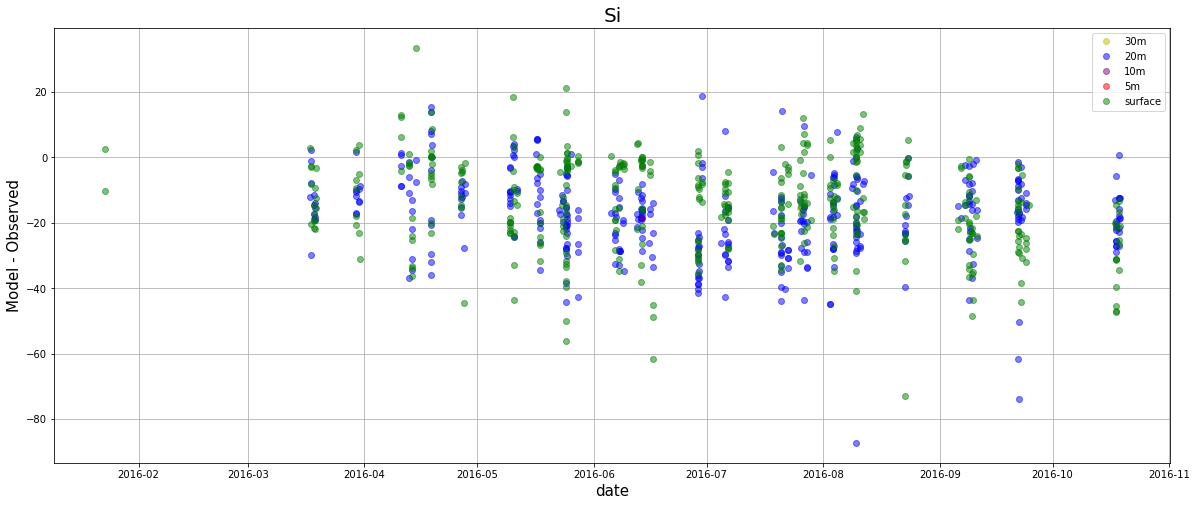

In [159]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes2[list_of_depths2 == 21], 
        list_of_model_si[list_of_depths2 == 21] 
        - list_of_cs_si[list_of_depths2 == 21], 'yo', alpha = 0.5, label = '30m')
ax.plot(list_of_datetimes2[list_of_depths2 == 18], 
        list_of_model_si[list_of_depths2 == 18] 
        - list_of_cs_si[list_of_depths2 == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_datetimes2[list_of_depths2 == 9], 
        list_of_model_si[list_of_depths2 == 9] 
        - list_of_cs_si[list_of_depths2 == 9], 'o', color = 'purple', alpha =0.5, label = '10m')
ax.plot(list_of_datetimes2[list_of_depths2 == 4], 
        list_of_model_si[list_of_depths2 == 4] 
        - list_of_cs_si[list_of_depths2 == 4], 'ro', alpha =0.5, label = '5m')
ax.plot(list_of_datetimes2[list_of_depths2 == 0], 
        list_of_model_si[list_of_depths2 == 0] 
        - list_of_cs_si[list_of_depths2 == 0], 'go', alpha =0.5, label = 'surface')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);